In [1]:
# import all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import technical analysis library 
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import SMAIndicator,EMAIndicator,MACD,macd_diff
from ta.volatility import BollingerBands,AverageTrueRange
from ta.momentum import ROCIndicator,RSIIndicator,StochRSIIndicator,TSIIndicator
from ta.others import CumulativeReturnIndicator,DailyLogReturnIndicator,DailyReturnIndicator

# Data Download from Yahoo Finance

In [2]:
# import yahoo finance library
import yfinance as yf 

# list of stock
stock_list = ['WFTUF','SWN','OKE','ITW','HAL','EQT','TKR','SLB']

for stock in stock_list:
    
    # download the data for each stock
    data = yf.download(stock, 
                        start='2020-01-01', 
                        end='2022-03-31')
    
    # consider only 'Adj Close' for further analysis
    wft_df = data[['Adj Close']]
    
    # rename column from 'Adj Close' to 'Close'
    wft_df.columns = ['Close']
    
    # drop any missing (NaN) rows.
    wft_df = dropna(wft_df)

    # feature generation
    
    # generate features from bollinger bands
    indicator_bb = BollingerBands(close=wft_df["Close"], window=20, window_dev=2)
    wft_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    wft_df['bb_bbh'] = indicator_bb.bollinger_hband()
    wft_df['bb_bbl'] = indicator_bb.bollinger_lband()

    # generate features from Simple moving average
    x = SMAIndicator(wft_df["Close"],10)
    wft_df['SMA10'] = x.sma_indicator()

    x = SMAIndicator(wft_df["Close"],15)
    wft_df['SMA20'] = x.sma_indicator()

    
    # generate features from Exponential moving average
    x = EMAIndicator(wft_df["Close"],10)
    wft_df['EMA10'] = x.ema_indicator()

    x = EMAIndicator(wft_df["Close"],15)
    wft_df['EMA20'] = x.ema_indicator()

    
    # generate features from MACD 
    x = MACD(wft_df["Close"])
    wft_df['macd'] = x.macd()

    wft_df['macd_diff'] = x.macd_diff()

    wft_df['macd_signal'] = x.macd_signal()

    # Generate features form ROC and RSI momentum indicator
    x = ROCIndicator(wft_df["Close"],10)
    wft_df['ROC10'] = x.roc()

    x = RSIIndicator(wft_df["Close"],10)
    wft_df['RSI10'] = x.rsi()

    x = StochRSIIndicator(wft_df["Close"],10)
    wft_df['StochRSI10'] = x.stochrsi()
    wft_df['StochRSID10'] = x.stochrsi_d()
    wft_df['StochRSIK10'] = x.stochrsi_k()

    x = TSIIndicator(wft_df["Close"],10)
    wft_df['TSIRSI10'] = x.tsi()

    # feature generation using return
    x = CumulativeReturnIndicator(wft_df["Close"],10)
    wft_df['Cum10'] = x.cumulative_return()

    x = DailyLogReturnIndicator(wft_df["Close"],10)
    wft_df['Dlog10'] = x.daily_log_return()

    x = DailyReturnIndicator(wft_df["Close"],10)
    wft_df['DRIND'] = x.daily_return()

    wft_df.dropna(inplace=True)
    wft_df.to_csv(f"{stock}.csv")
    print(f'feature creation for {stock} completed')


[*********************100%***********************]  1 of 1 completed
feature creation for WFTUF completed
[*********************100%***********************]  1 of 1 completed
feature creation for SWN completed
[*********************100%***********************]  1 of 1 completed
feature creation for OKE completed
[*********************100%***********************]  1 of 1 completed
feature creation for ITW completed
[*********************100%***********************]  1 of 1 completed
feature creation for HAL completed
[*********************100%***********************]  1 of 1 completed
feature creation for EQT completed
[*********************100%***********************]  1 of 1 completed
feature creation for TKR completed
[*********************100%***********************]  1 of 1 completed
feature creation for SLB completed


# Lasso regression

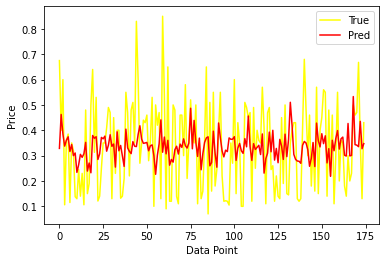

Close  ->  -0.004284023613164586
bb_bbm  ->  0.003908397911555272
bb_bbh  ->  0.0032198527398336865
bb_bbl  ->  0.008941717190358882
SMA10  ->  0.016444740874905855
SMA20  ->  -0.009578876075281316
EMA10  ->  0.006825737297109496
EMA20  ->  0.008211809357814438
macd  ->  -0.009354320856370456
macd_diff  ->  0.013732160421768195
macd_signal  ->  -0.004392846595849556
ROC10  ->  -0.012221364217120325
RSI10  ->  0.01262642320071952
StochRSI10  ->  -0.008507408879748478
StochRSID10  ->  -0.005275958180609814
StochRSIK10  ->  -0.005223440574993573
TSIRSI10  ->  -0.01344988714504811
Cum10  ->  -0.004284023613165222
Dlog10  ->  -0.005726870131993925
DRIND  ->  -0.010668466650880644


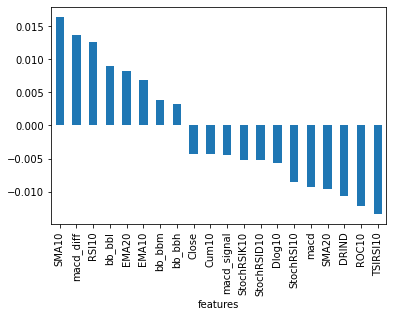

In [3]:
# Importing libraries 
# https://www.geeksforgeeks.org/implementation-of-lasso-regression-from-scratch-using-python/
# https://towardsdatascience.com/ml-from-scratch-linear-polynomial-and-regularized-regression-models-725672336076

# Lasso Regression

class LassoRegression() :

    def __init__( self, learning_rate, iterations, l1_penality ) :

        self.learning_rate = learning_rate
        
        self.iterations = iterations
        
        self.l1_penality = l1_penality
        
    # Function for model training

    def fit( self, X, Y ) :
        
        # no_of_training_examples, no_of_features
        
        self.m, self.n = X.shape
        
        # weight initialization
        
        self.W = np.zeros( self.n )
        
        self.b = 0
        
        self.X = X
        
        self.Y = Y
        
        # gradient descent learning

        for i in range( self.iterations ) :

            self.update_weights()

        return self

    # Helper function to update weights in gradient descent

    def update_weights( self ) :

        Y_pred = self.predict( self.X )
        
        # calculate gradients
        
        dW = np.zeros( self.n )
        
        for j in range( self.n ):
            
            if self.W[j] > 0 :
                
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                        
                        + self.l1_penality ) / self.m
            else :
                
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) )
                        
                        - self.l1_penality ) / self.m

        db = - 2 * np.sum( self.Y - Y_pred ) / self.m
        
        # update weights
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        
        return self

    # Hypothetical function h( x )
    
    def predict( self, X ) :
    
        return X.dot( self.W ) + self.b

def main() :
    
    # Importing dataset
    
    df = pd.read_csv('WFTUF.csv')
    feature_names = list(df)[1:]
    df['Target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)

    X = df.iloc[:, 1:-1].values
    Y = df.iloc[:, -1].values
    
    sc_X = StandardScaler()
    X = sc_X.fit_transform(X)
    # Splitting dataset into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 1 / 3, random_state = 0 )
    
    # Model training
    
    model = LassoRegression( iterations = 1000, learning_rate = 0.01, l1_penality = 500 )
    model.fit( X_train, Y_train )
    
    # Prediction on test set
    Y_pred = model.predict( X_test )
    plt.plot( list(range(len(Y_test))), Y_test, color = 'yellow',label='True')
    plt.plot( list(range(len(Y_test))), Y_pred, color = 'red' ,label='Pred')

    plt.xlabel( 'Data Point' )
    
    plt.ylabel( 'Price' )
    plt.legend()
    plt.show()
    return model.W,X_train,feature_names

if __name__ == "__main__" :
    coeff,X_train,feature_names = main()
    t = np.std(X_train, 0)*np.array(coeff)
    for i,j in zip(feature_names,t):
        print(i,' -> ',j)

    dff = pd.DataFrame([])
    dff['features'] = feature_names
    dff['importance'] = t

    d = dff.groupby(['features']).sum().sort_values('importance',ascending=False)
    d['importance'].plot.bar()